In [22]:
import scipy
import scipy.spatial
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import time
%load_ext line_profiler
import line_profiler
%load_ext Cython


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [23]:
def directed_hausdorff_brute_force(u, v):
    return max(np.amin(scipy.spatial.distance.cdist(u,v), axis = 1))


In [24]:
from Cython.Compiler.Options import directive_defaults

directive_defaults['linetrace'] = True
directive_defaults['binding'] = True

In [157]:
%%cython -a -f --compile-args=-DCYTHON_TRACE=1

import numpy as np
cimport numpy as np
cimport cython
from libc.math cimport sqrt

@cython.boundscheck(False)
def directed_hausdorff(np.ndarray[np.float64_t, ndim =2] ar1, np.ndarray[np.float64_t, ndim =2] ar2):
    """ Calculates the directed Hausdorff distance between point sets.
    
    Notes
    ----------
    Uses the early break technique and the random sampling approach described
    by Taha and Hanbury (2015) IEEE Transactions On Pattern Analysis And Machine
    Intelligence 37. Although worst-case performance is polynomial (as with the
    brute force algorithm), this is exceedingly unlikely in practice, and
    almost-linear time complexity performance can normally be expected for the
    average case.
    """

    # shuffling the points in each array generally increases the likelihood of
    # an advantageous break in the inner search loop and never decreases the
    # performance of the algorithm
    cdef double cmax, cmin
    cdef int break_occurred
    cdef int N1 = ar1.shape[0]
    cdef int N2 = ar2.shape[0]
    cdef int data_dims = ar1.shape[1]
    cdef double square_distance = 0
    cdef np.float64_t d

    np.random.shuffle(ar1)
    np.random.shuffle(ar2)
                                                                                                                                                                                                     
    cmax = 0 
    for i in range(N1):
        break_occurred = 0
        cmin = np.inf
        for j in range(N2):
            d = 0
            for k in range(data_dims):
                d += ((ar1[<unsigned int> i,<unsigned int> k] - ar2[<unsigned int> j,<unsigned int> k]) * (ar1[<unsigned int> i,<unsigned int> k] - ar2[<unsigned int> j,<unsigned int> k]))
            if d < cmax: # early break
                break_occurred += 1
                break
            if d < cmin:
                cmin = d
        if cmin > cmax and cmin != np.inf and break_occurred == 0:
            cmax = cmin
    return sqrt(cmax)


In [177]:
points_per_array = 400
u = np.random.random((points_per_array, 3))
v = np.random.random((points_per_array, 3))

%lprun -f directed_hausdorff directed_hausdorff(u,v)

In [181]:
def test_approach(func, u, v, num_times = 3):
    times = []
    for i in range(num_times):
        start = time.time()
        d = func(u,v)
        end = time.time()
        times.append(end - start)
    print 'd:', d
    return np.mean(times)


In [182]:
# interleave performance tests
brute_times = []
new_algorithm_times = []
total_points = np.linspace(400,20000,num=16)
for point_total in total_points:
    points_per_array = int(point_total / 2)
    u = np.random.random((points_per_array, 3))
    v = np.random.random((points_per_array, 3))
    
    # brute force approach bench
    brute_force_avg_time = test_approach(directed_hausdorff_brute_force, u, v, num_times = 3)
    brute_times.append(brute_force_avg_time)
    
    # new algorithm bench
    new_algorithm_avg_time = test_approach(directed_hausdorff, u, v, num_times = 3)
    new_algorithm_times.append(new_algorithm_avg_time)

d: 0.216858888103
d: 0.216858888103
d: 0.18171007181
d: 0.18171007181
d: 0.125503992664
d: 0.125503992664
d: 0.107384039451
d: 0.107384039451
d: 0.0950160376874
d: 0.0950160376874
d: 0.101729248326
d: 0.101729248326
d: 0.0970293561687
d: 0.0970293561687
d: 0.0778702677733
d: 0.0778702677733
d: 0.0875023779655
d: 0.0875023779655
d: 0.0865464913164
d: 0.0865464913164
d: 0.0715954174314
d: 0.0715954174314
d: 0.0746863896851
d: 0.0746863896851
d: 0.0699168449504
d: 0.0699168449504
d: 0.0680685871293
d: 0.0680685871293
d: 0.0678793443601
d: 0.0678793443601
d: 0.0687736503893
d: 0.0687736503893


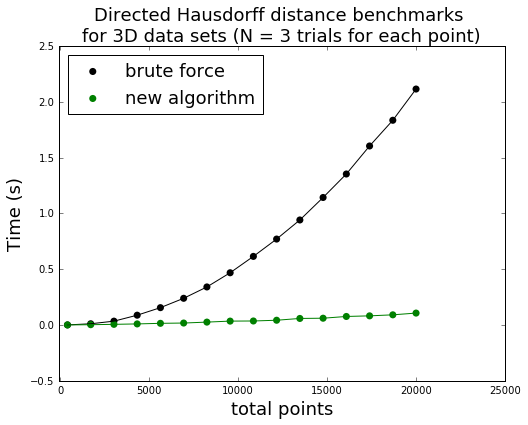

In [192]:
fig = plt.figure()
ax = fig.add_subplot('111')
ax.scatter(total_points, brute_times, color = 'black', edgecolor='none', label = 'brute force', s = 50)
ax.plot(total_points, brute_times, color = 'black')
ax.scatter(total_points, new_algorithm_times, color = 'green', edgecolor='none', label = 'new algorithm', s = 50)
ax.plot(total_points, new_algorithm_times, color = 'green')
ax.legend(loc=2, scatterpoints=1, fontsize=18)
ax.set_ylabel('Time (s)', fontsize = 18)
ax.set_xlabel('total points', fontsize = 18)
ax.set_title('Directed Hausdorff distance benchmarks \nfor 3D data sets (N = 3 trials for each point)', fontsize = 18)
ax.set_xlim(-100,25000)
fig.set_size_inches(8,6)